In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

import os
import numpy as np
import matplotlib.pyplot as plt

source_path = "/content/drive/My Drive/Data" #cambiar a la ubicación donde tengas las carpetas de train y test
NUM_CLASSES = 3
tam = (450,600) # Este es el tamaño al que se reescalaran las imagenes. Este valor permite entrenar sin problemas de memoria, pero usar mayor tamaño si se dispone del hardware suficiente
batch_size = 32
modelos = 0


Para empezar, conviene explorar un poco los datos. Con el siguiente fragmento de codigo, sacaremos la primera imagen de entrenamiento de la primera carpeta (la que encuentre Python) de nuestro dataset. De ahi sacaremos el tamaño de las imagenes, que nos sera util más adelante, y mostraremos una imagen de cada clase para tener una idea de a que problema nos enfrentamos

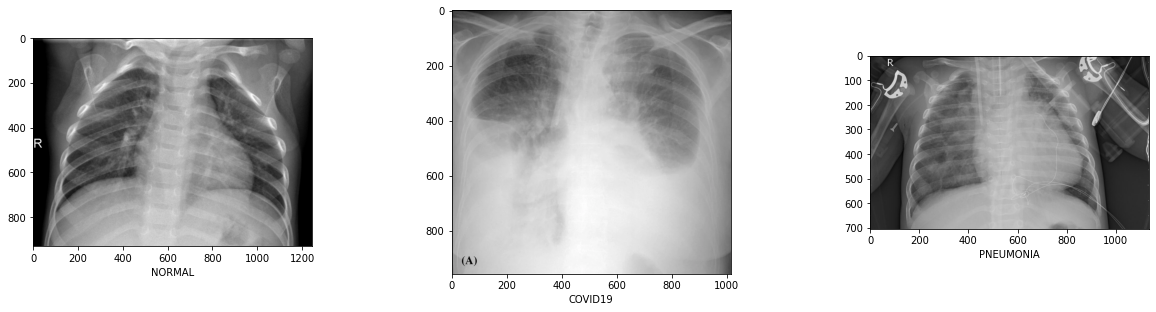

In [2]:
train = os.path.join(source_path, "train")
primeras_imagenes = []
for _, clases, _ in os.walk(train):
    for clase in clases:
        #Aqui se alojan muchas variables que hacen ineficiente en memoria el codigo, pero dejan para facilitar la legibilidad 
        ruta_clase = os.path.join(train, clase)
        ruta_imagen = next(os.walk(ruta_clase))[2][0]
        imagen = plt.imread(os.path.join(ruta_clase, ruta_imagen))
        primeras_imagenes.append((imagen, clase))

fig, ((ax1), (ax2), (ax3)) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(primeras_imagenes[0][0])
ax1.set_xlabel(primeras_imagenes[0][1])
ax2.imshow(primeras_imagenes[1][0])
ax2.set_xlabel(primeras_imagenes[1][1])
ax3.imshow(primeras_imagenes[2][0])
ax3.set_xlabel(primeras_imagenes[2][1])
plt.subplots_adjust(wspace=0.5)
plt.show()
tamaño = primeras_imagenes[0][0].shape
# El tamaño es distinto en cada foto, pero es orientativo

Usando las librerias de preprocesado de Keras, creamos una serie de generadores de imagenes que nos ayudarán al entrenamiento de forma eficiente. Este objeto se encarga de realizar una transformación aleatoria a los datos que se le cargen, aportando por tanto Data Augmentation, la cual es una técnica que mejora el entrenamiento previniendo el overfitting.

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,   #Reescalado de la imagen
    shear_range=0.2,  #Intensidad de una posible distorsión
    zoom_range=0.2,   #Rango para un posible zoom aleatorio
    horizontal_flip=True)  #De forma aleatoria, invierte la imagen

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
        os.path.join(source_path, "train"),
        target_size=tam,
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        os.path.join(source_path, "test"),
        target_size=tam,
        batch_size=batch_size,
        class_mode='categorical')


Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


Para probar como funciona, vamos a obtener el primer elemento y vamos a imprimir la imagen correspondiente

Tenemos un primer batch con forma: (32, 450, 600, 3)


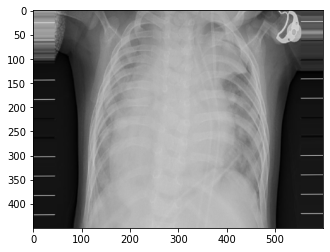

In [5]:
print(f"Tenemos un primer batch con forma: {next(train_generator)[0].shape}")
plt.imshow(next(train_generator)[0][0], cmap="gray")
plt.show()

In [6]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(*tam, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e4),
              metrics=['acc'])

In [8]:
history = model.fit(train_generator,
                   steps_per_epoch = 100,
                   epochs = 2)


Epoch 1/2
100/100 [==============================] - 1733s 17s/step - loss: 401034245304293760182517760.0000 - acc: 0.5442
Epoch 2/2
100/100 [==============================] - 808s 8s/step - loss: 59983457560236067657875456.0000 - acc: 0.6012


In [9]:
model.save(os.path.join(os.path.join(source_path, f"modelo.h5")))
model = load_model(os.path.join(os.path.join(source_path, f"modelo_best.h5")))

In [12]:
model.save_weights(os.path.join(source_path, "modelo_best_weights.h5"))

In [10]:
model.evaluate(test_generator)

41/41 [==============================] - 656s 16s/step - loss: 0.5737 - acc: 0.7686


[0.5737361311912537, 0.7686335444450378]

In [11]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 450, 600, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 225, 300, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 223, 298, 64)      18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 149, 64)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1058496)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               135487616 
_________________________________________________________________
dense_9 (Dense)              (None, 3)                